# Throughput Analysis 

This notebook compares the messaging throughput of three Go systems libraries:

1. ZMQ REP/REQ sockets (rep) 
2. ZMQ ROUTER/DEALER sockets (router) 
3. gRPC HTTP connection (grpc) 

The code for the implementations can be found at [github.com/bbengfort/rtreq](https://github.com/bbengfort/rtreq) and [github.com/bbengfort/echo](https://github.com/bbengfort/echo). 

## Data Loading

In [1]:
%matplotlib inline 

import os 
import json 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from collections import defaultdict

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Set1')

In [2]:
# Fixtures and constants 
FIXTURES = os.path.join(".", "fixtures")
RESULTS = os.path.join(FIXTURES, "results")
HOSTS = os.path.join(FIXTURES, "hosts.txt")

SERVER = 0 
SAVEFIG = True 
CLUSTER = "UMD"

In [7]:
def load_hosts(path=HOSTS, clients=True):
    idx = -1 
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith("#"):
                idx += 1 
                if clients and idx == SERVER:
                    continue 
                yield line

                
def load_results(path=RESULTS, hosts=HOSTS):
    results = defaultdict(lambda: defaultdict(list))
    
    for host in load_hosts(hosts):
        for name in os.listdir(os.path.join(path, host)):
            fpath = os.path.join(path, host, name)
            system = name.split("-")[1]
            
            with open(fpath, 'r') as f:
                for line in f:
                    data = json.loads(line) 
                    data['host'] = host 
                    data['system'] = system 
                    results[system][data['n_clients']].append(data)
    
    return results


def make_dataframe(path=RESULTS, hosts=HOSTS):
    for system, results in load_results().items():
        for clients, rows in results.items():
            data = {
                'system': system, 
                'clients': clients, 
                'duration': 0.0, 
                'messages': 0.0, 
                'maximum latency': None, 
                'minimum latency': None, 
                'throughput': 0.0,
                'nrows': 0,
            }
            
            for row in rows:
                data['nrows'] += 1
                data['duration'] += float(row['latency (nsec)'])
                data['messages'] += float(row['messages'])
                data['throughput'] += float(row['throughput (msg/sec)'])
                
                if data['maximum latency'] is None or data['maximum latency'] < row['latency distribution']['maximum']:
                    data['maximum latency'] = float(row['latency distribution']['maximum'])
                    
                if data['minimum latency'] is None or data['minimum latency'] > row['latency distribution']['minimum']:
                    data['minimum latency'] = float(row['latency distribution']['minimum'])
            
            data['mean latency'] = data['duration'] / data['messages']
            yield data 

In [8]:
results = pd.DataFrame(list(make_dataframe()))
results

,clients,duration,maximum latency,mean latency,messages,minimum latency,nrows,system,throughput
0,1,2.929722e+10,545880.0,1.057700e+06,27699.0,3398081.0,1,grpc,945.447943
1,2,5.855505e+10,505930.0,8.854804e+05,66128.0,2924987.0,2,grpc,2258.586470
2,3,8.773172e+10,649967.0,9.254401e+05,94800.0,2395189.0,3,grpc,3241.377769
3,4,1.175902e+11,91011012.0,1.244222e+06,94509.0,2569063.0,4,grpc,3233.578957
4,5,1.472188e+11,90977168.0,1.135483e+06,129653.0,2325416.0,5,grpc,4422.066058
5,6,1.768529e+11,90584861.0,1.049871e+06,168452.0,2311978.0,6,grpc,5729.438390
6,7,2.058125e+11,91172481.0,1.048844e+06,196228.0,2366274.0,7,grpc,6690.784105
7,8,2.357567e+11,90791033.0,1.197269e+06,196912.0,2362653.0,8,grpc,6714.789740
8,9,2.651645e+11,91221208.0,1.156318e+06,229318.0,2628610.0,9,grpc,7815.252797
9,10,2.947459e+11,91210502.0,1.097403e+06,268585.0,2885768.0,10,grpc,9141.156373


## Throughput Over Clients 

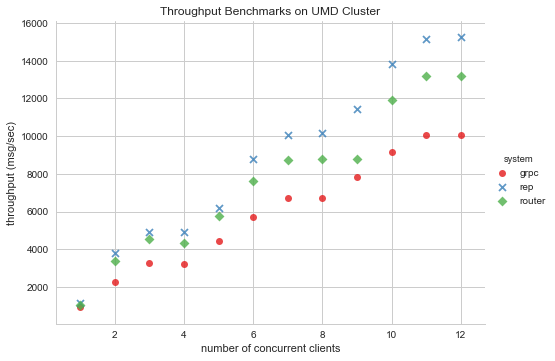

In [9]:
g = sns.lmplot(
    x="clients", y="throughput", hue="system", 
    fit_reg=False, aspect=1.4,
    data=results, markers=["o", "x", "D"],

)

ax = g.axes[0][0]
ax.set_ylabel("throughput (msg/sec)")
ax.set_xlabel("number of concurrent clients")
ax.set_title("Throughput Benchmarks on {} Cluster".format(CLUSTER))

if SAVEFIG:
    plt.savefig("fixtures/images/throughput-{}.pdf".format(CLUSTER))
    plt.savefig("fixtures/images/throughput-{}.png".format(CLUSTER))

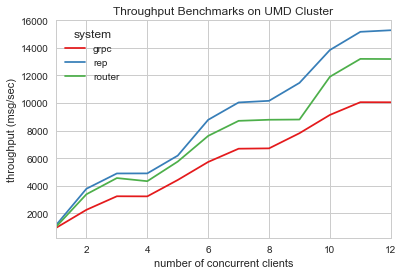

In [6]:
df = results.pivot('clients', columns='system')['throughput']
g = df.plot()
g.set_ylabel("throughput (msg/sec)")
g.set_xlabel("number of concurrent clients")
g.set_title("Throughput Benchmarks on {} Cluster".format(CLUSTER))

if SAVEFIG:
    plt.savefig("fixtures/images/throughput-{}.pdf".format(CLUSTER))
    plt.savefig("fixtures/images/throughput-{}.png".format(CLUSTER))